In [1]:
import xmltodict
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels as st
import statsmodels.api as sm
from scipy import stats
from pandas import DataFrame
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.parser import parse
import scipy.stats as scs
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

#Stop warnings
import warnings
warnings.filterwarnings("ignore")

#### Read Data

In [2]:
def read_QS_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Extract datetime information
    dat["Datetime"] = pd.to_datetime(dat["Start"], format = '%d-%b-%Y %H:%M')
    dat["Date"] = dat["Datetime"].dt.date
    dat["Hour"] = dat["Datetime"].dt.hour
    #Format columns
    dat = dat[["Date", "Hour", "Steps (count)"]]
    dat.columns = ["Date", "Hour", "Steps"]
    
    return dat

def read_Pacer_data(filename):
    #Read in the data
    dat = pd.read_csv(filename)
    #Select necessary columns
    dat = dat[["date","steps"]]
    #Extract datetime data
    dat["datetime"] = pd.to_datetime(dat["date"], format = '%m/%d/%Y, %H:%M:%S %z')
    dat["Date"] = dat["datetime"].dt.date
    dat["Hour"] = dat["datetime"].dt.hour
    dat["Min"] = dat["datetime"].dt.minute
    #Aggregate over the hours
    dat = dat.groupby(["Date","Hour"])["steps"].agg("sum").reset_index()
    #Relabel columns
    dat.columns = [["Date", "Hour", "Steps"]]
    
    return dat

def read_XML_data(filename):
    #Read in XML file
    with open(filename, 'r') as xml_file:
        input_data = xmltodict.parse(xml_file.read())
    #Extract record data from XML
    record_list = input_data['HealthData']['Record']
    df = pd.DataFrame(record_list)
    #Convert dates to datetime objects and steps to numeric
    date_format = '%Y-%m-%d %H:%M:%S %z'
    df['@startDate'] = pd.to_datetime(df['@startDate'], format = date_format)
    df['@endDate'] = pd.to_datetime(df['@endDate'], format = date_format)
    df['@value'] = pd.to_numeric(df['@value'])
    #Sum up values for each hour
    dat = df.resample("H", on="@startDate").sum().reset_index()
    #Extract date and hour information, and relabel columns
    dat["Date"] = dat["@startDate"].dt.date
    dat["Hour"] = dat["@startDate"].dt.hour
    dat["Steps"] = dat["@value"]
    dat = dat[["Date","Hour","Steps"]]
    
    return dat

def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat

#### Input Pipeline

In [3]:
def read_step_data(filename, read_type):
    read_type = read_type.lower()
    print("reading: " + filename)
    if read_type == "pacer":
        return read_Pacer_data(filename)
    elif read_type == "qsaccess" or read_type == "qs":
        return read_QS_data(filename)
    elif read_type == "xml":
        return read_XML_data(filename)
    elif read_type == "clean" or read_type == "cleaned":
        return read_CLEAN_data(filename)
    else:
        raise Exception("Not a valid file type to read! Use pacer, qs, xml or clean")

#### Adherence and Methods

In [4]:
# 10 hours of non zeroes 
def ten_hours_non_zeros(df,hours):
    df1 = df.copy()
    df1['Not Zero'] = df1['Steps'] > 0
    df1 = df1.groupby('Date').sum()
    df1 = df1['Not Zero'] > hours 
    return df1

#Greater than 500 steps
def greater_than_certain_steps(df,min_steps):
    df1 = df.copy()
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps']> min_steps
    return df1


#Active in 3 time blocks 
def three_time_blocks(df):
    df1 = df.copy()
    bins = [-1,2,10,14,25,np.inf]
    names = ['3','1','2', '4', '5']
    df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names)
    df1 = df1.replace({'3timeblock':r'4'},{'3timeblock':'3'},regex = True)
    df1 = df1.replace({'3timeblock':r'5'},{'3timeblock':'3'},regex = True)
    df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
    df1['Steps within timeblock'] = df1['Steps']> 0 
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps within timeblock'] ==3 
    return df1

#Combining it all into 1 dataframe
def three_method_table(x):
    valid_1= ten_hours_non_zeros(x,10)
    valid_2= greater_than_certain_steps(x,500)
    valid_3= three_time_blocks(x)
    result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
    result.reset_index(level=0, inplace=True)
    result.columns = ["Date", "Ten Hours Non Zero","Steps > Five Hundred","Three Timeblock"]
    result['All Three True'] = result["Three Timeblock"]*result["Ten Hours Non Zero"]*result["Steps > Five Hundred"]
    result_sum = result.sum()
    return result , result_sum

def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['Ten Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > Five Hundred'] == True)
    elif(measure == 3):
        mask = (df3['Three Timeblock'] == True)    
    elif(measure == 4):
        mask = (df3['All Three True'] == True)
    filtered_df = df3.loc[mask].drop(['Ten Hours Non Zero', 'Steps > Five Hundred', 'Three Timeblock', 'All Three True'], axis=1)

    return filtered_df

# Method 1 calculates daily steps based on all the step activity that is available during the day
def all_step_activity(df):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def top_ten_most_active_hours(df):
    df = df.copy()
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def ten_hour_time_block(df, start_hour, end_hour):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

def calculate_daily_steps(file_name, read_type, filter_measure, start_time, end_time):
    df = read_step_data(filename, read_type)
    filtered_df = filter_by_adherence(df, filter_measure)
    dailysteps_method2 = top_ten_most_active_hours(filtered_df)
    dailysteps_method1 = all_step_activity(filtered_df)
    dailysteps_method3 = ten_hour_time_block(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3

In [5]:
filename = "serena.csv"

filter_measure = 1
read_type = "clean"
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = calculate_daily_steps(filename, read_type, filter_measure, start_time, end_time)

reading: serena.csv


#### Method 1

In [6]:
ds_method1.set_index('Date',inplace=True)
ds_method1.shape

(1035, 1)

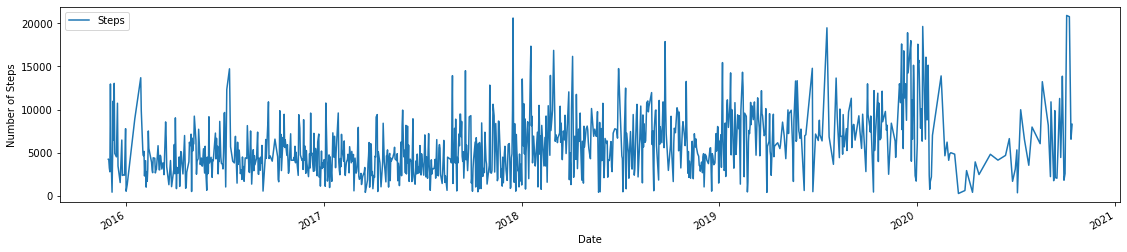

In [7]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

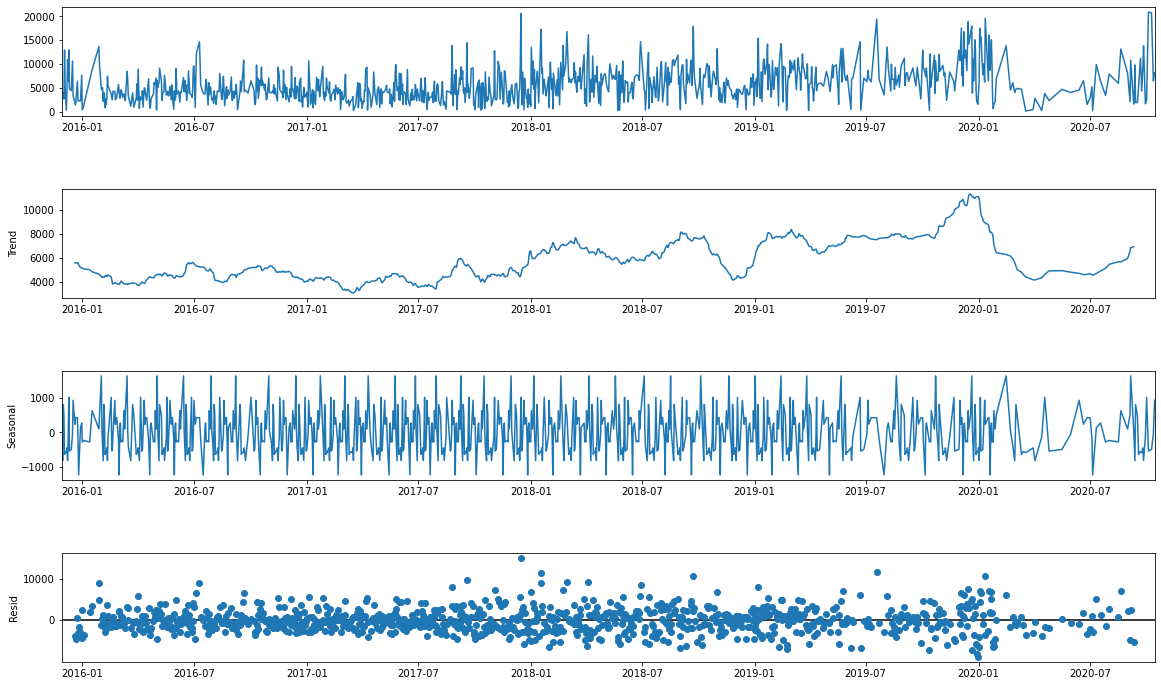

In [8]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', freq = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

The data still has some missing seasonality, but we'll still use SARIMA. 

#### Check for data stationary

In [9]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

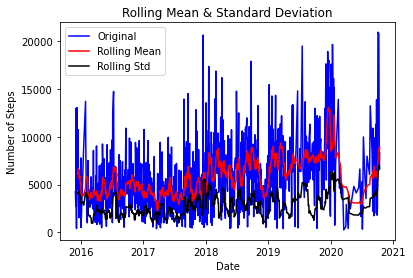

Results of Dickey Fuller Test:
ADF Test Statistic               -3.134681
p-value                           0.024091
#Lags Used                       22.000000
Number of Observations Used    1012.000000
Critical Value (1%)              -3.436828
Critical Value (5%)              -2.864400
Critical Value (10%)             -2.568293
dtype: float64


In [10]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 0.024091 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

#### (S)ARIMA Parameters

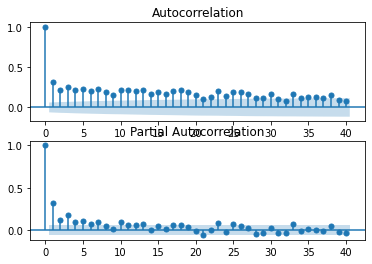

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0], lags = 40)
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1], lags = 40)
plt.show()

In [12]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method1, start_p=0, start_q=0,
                           max_p=7, max_q=10, m=12,
                            seasonal=True,
                           d=0 , trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=19837.672, BIC=19857.440, Fit time=1.793 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=19832.958, BIC=19842.842, Fit time=0.029 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=19714.960, BIC=19734.729, Fit time=0.551 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=19733.152, BIC=19752.921, Fit time=0.397 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=19723.578, BIC=19738.405, Fit time=0.138 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=19716.898, BIC=19741.609, Fit time=1.771 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=19715.472, BIC=19740.183, Fit time=1.369 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=19716.686, BIC=19746.339, Fit time=3.224 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=19822.604, BIC=19837.430, Fit time=0.386 seconds
Fit ARIMA:

So, the best set of paramters to select is ARIMA(4,0,5)(0,0,0,12). I selected m = 12 to represent the yearly number of months each 'season' runs for.

Optimization terminated successfully.
         Current function value: 9.478518
         Iterations: 2
         Function evaluations: 229


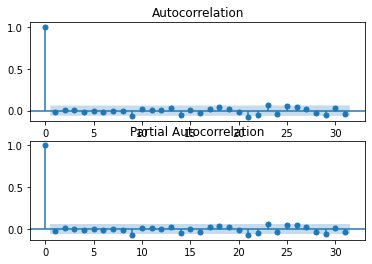

In [13]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(4,0,5), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

In [19]:
train = ds_method1.loc['2015-11-29':'2019-03-08']
test = ds_method1.loc['2020-10-14':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(4, 0, 5),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [20]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(4, 0, 5),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1035
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -9749.146
Date:                Wed, 18 Nov 2020   AIC                          19518.292
Time:                        14:45:08   BIC                          19567.656
Sample:                             0   HQIC                         19537.028
                               - 1035                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1938      0.422     -0.459      0.646      -1.021       0.634
ar.L2         -0.1000      0.107     -0.938      0.348      -0.309       0.109
ar.L3          0.8565      0.095      9.008      0.0

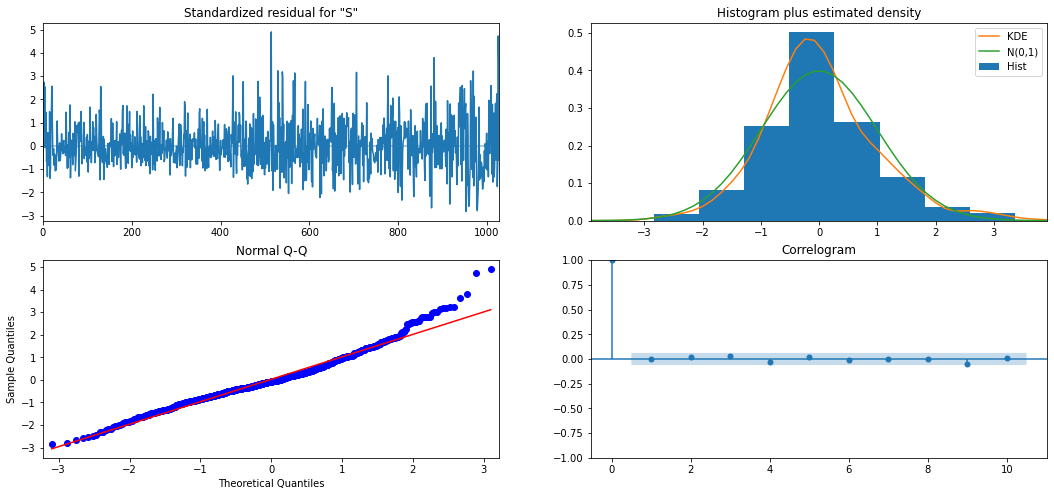

In [21]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

#### (S)ARIMA Model Validation

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [23]:
# the 20% point test data is on the specified date below
split_date = '2019-03-08'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(4, 0, 5),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [24]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 18858133.4956
Root Mean Squared Error: 4342.5952
Mean Absolute Error: 3419.9546


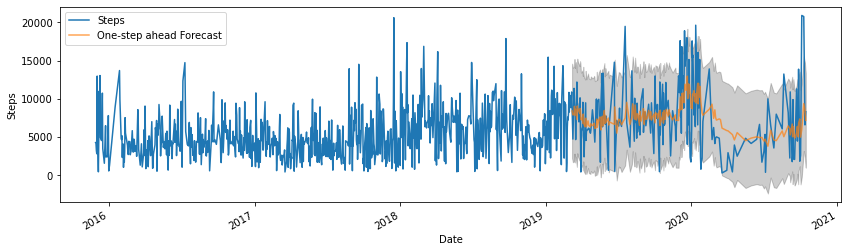

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2019-03-08'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 2

In [26]:
ds_method2.set_index('Date',inplace=True)
ds_method2.head()

,Steps
Date,
2015-11-29,4115.703713
2015-11-30,4013.000000
2015-12-01,3191.000000
2015-12-02,2724.000000
2015-12-03,12851.000000


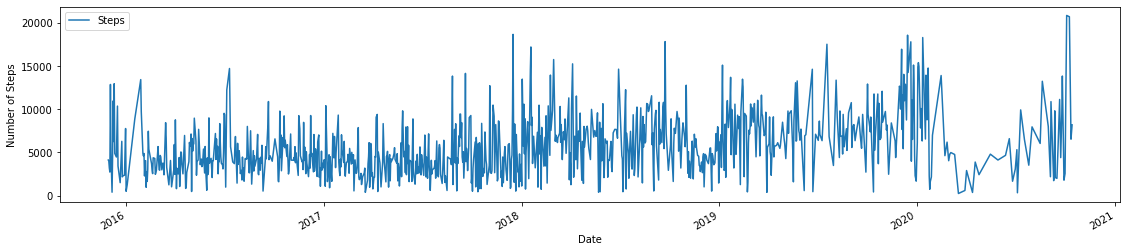

In [27]:
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

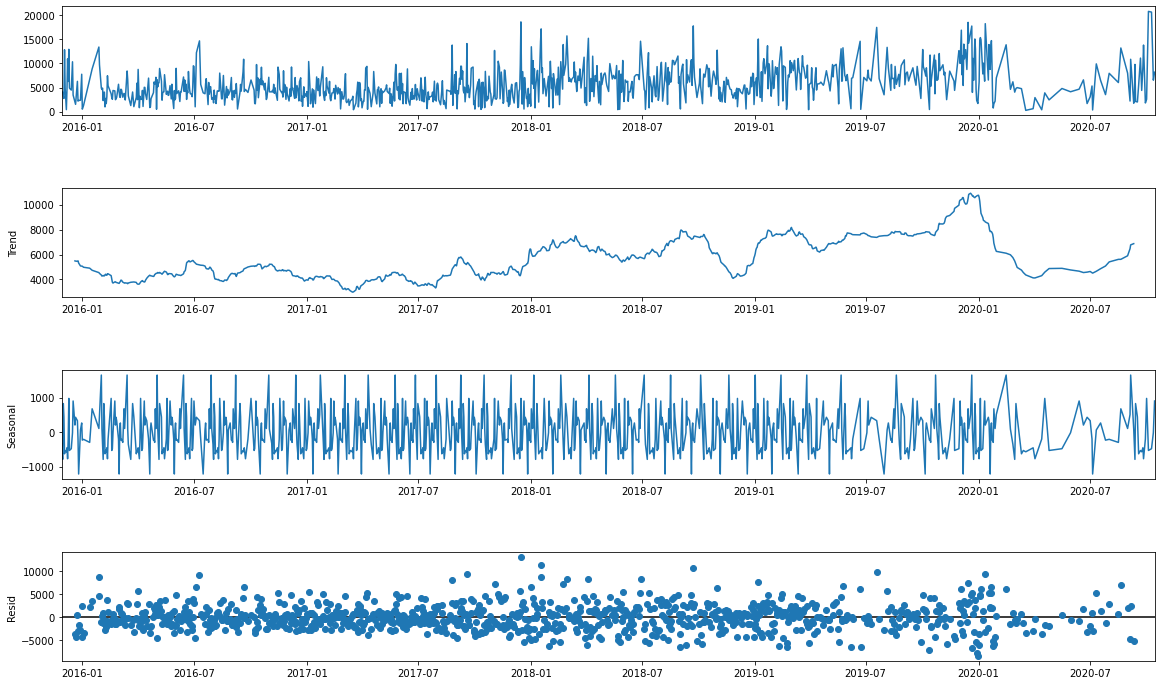

In [28]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, data is missing some seasonal data

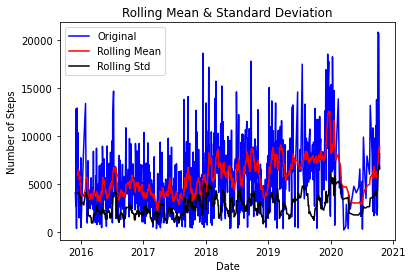

Results of Dickey Fuller Test:
ADF Test Statistic               -3.094960
p-value                           0.026928
#Lags Used                       22.000000
Number of Observations Used    1012.000000
Critical Value (1%)              -3.436828
Critical Value (5%)              -2.864400
Critical Value (10%)             -2.568293
dtype: float64


In [29]:
test_stationarity(ds_method2)

Data appears to be stationary

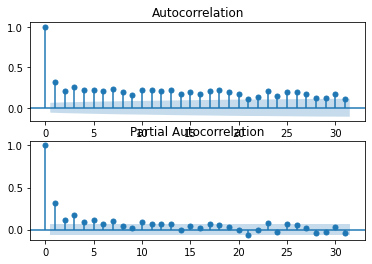

In [30]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

In [32]:
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=7, max_q=9, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=20248.610, BIC=20268.379, Fit time=1.844 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=19775.461, BIC=19785.345, Fit time=0.052 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=19656.064, BIC=19675.833, Fit time=0.646 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=19673.940, BIC=19693.709, Fit time=0.468 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=19664.597, BIC=19679.423, Fit time=0.099 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=19657.951, BIC=19682.662, Fit time=1.936 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=19656.639, BIC=19681.349, Fit time=1.316 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=19657.672, BIC=19687.325, Fit time=3.655 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=19765.194, BIC=19780.021, Fit time=0.351 seconds
Fit ARIMA:

Best SARIMA is  order=(4,0,5) seasonal_order=(0, 0, 0, 12)

Optimization terminated successfully.
         Current function value: 9.449171
         Iterations: 2
         Function evaluations: 229


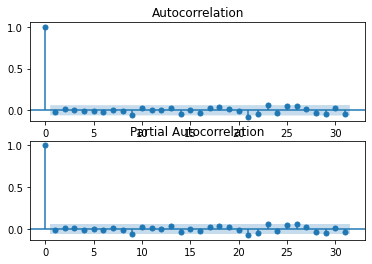

In [36]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(4,0,5), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

In [37]:
train = ds_method2.loc['2015-11-29':'2019-03-08']
test = ds_method2.loc['2020-10-14':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(4, 0, 5),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [38]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(4,0,5),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1035
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -9718.394
Date:                Wed, 18 Nov 2020   AIC                          19456.788
Time:                        14:50:22   BIC                          19506.151
Sample:                             0   HQIC                         19475.523
                               - 1035                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4757      0.183     -2.597      0.009      -0.835      -0.117
ar.L2         -0.0270      0.049     -0.547      0.584      -0.124       0.070
ar.L3          0.7961      0.049     16.133      0.0

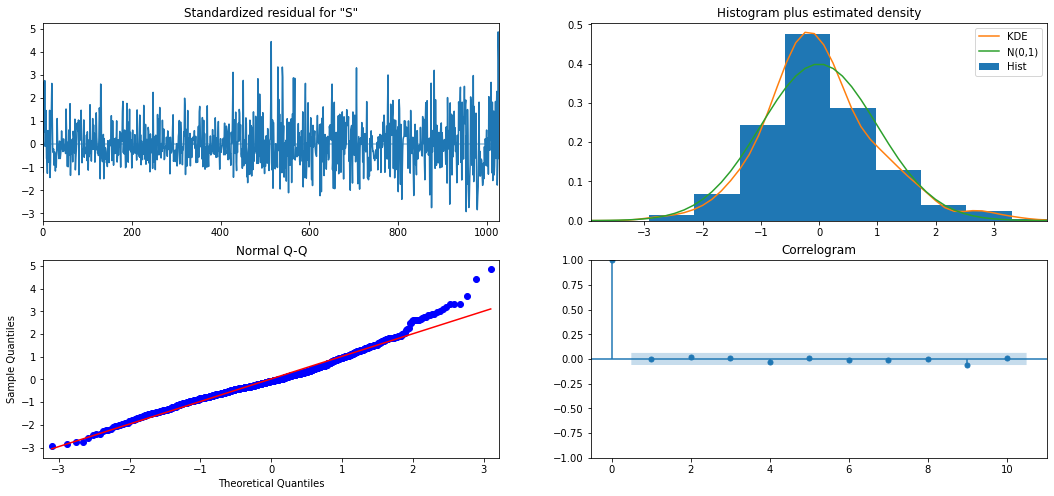

In [39]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [40]:
# the 20% point test data is on the specified date below
split_date = '2019-03-08'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(4,0,5),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [41]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 17204495.0041
Root Mean Squared Error: 4147.8302
Mean Absolute Error: 3247.8271


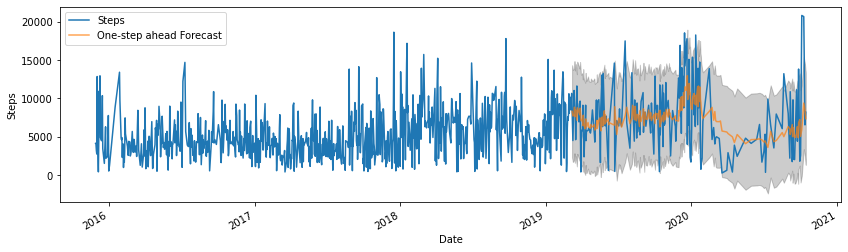

In [42]:
pred = results.get_prediction(start=pd.to_datetime('2019-03-08'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 3

In [43]:
ds_method3.set_index('Date',inplace=True)
ds_method3.head()

,Steps
Date,
2015-11-29,4080.573591
2015-11-30,3906.552367
2015-12-01,2979.000000
2015-12-02,2544.000000
2015-12-03,12674.000000


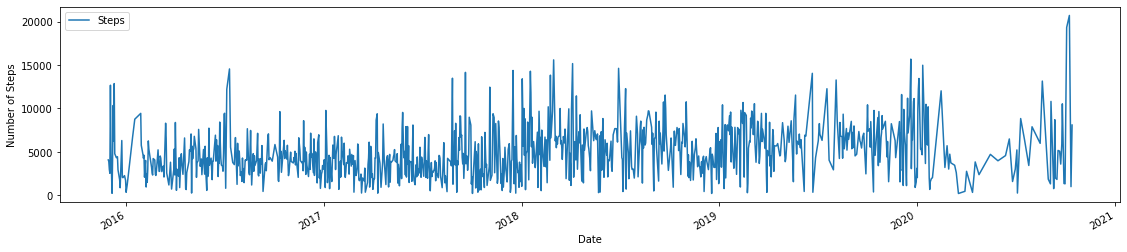

In [44]:
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

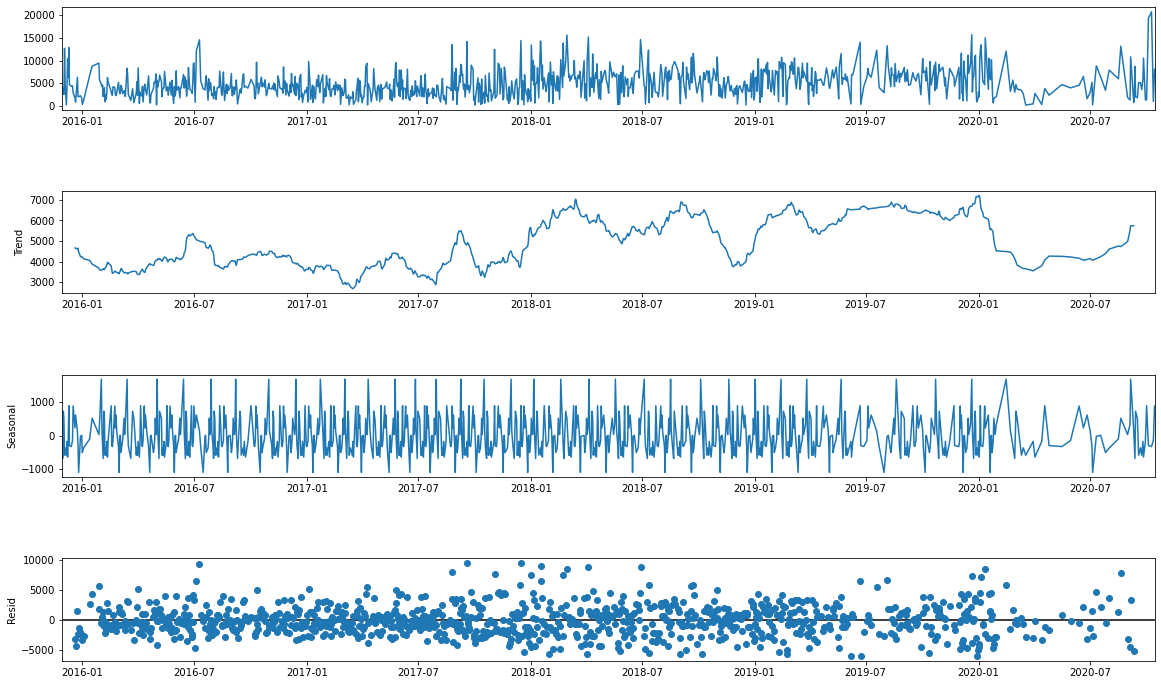

In [45]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, our data is missing some seasonal data

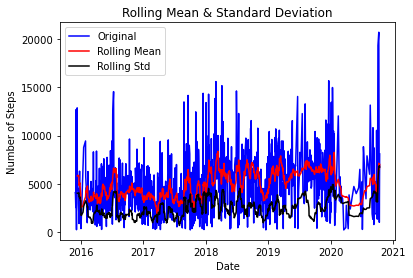

Results of Dickey Fuller Test:
ADF Test Statistic               -4.885104
p-value                           0.000037
#Lags Used                       12.000000
Number of Observations Used    1022.000000
Critical Value (1%)              -3.436765
Critical Value (5%)              -2.864372
Critical Value (10%)             -2.568278
dtype: float64


In [46]:
test_stationarity(ds_method3)

P-value is significant, our data is stationary

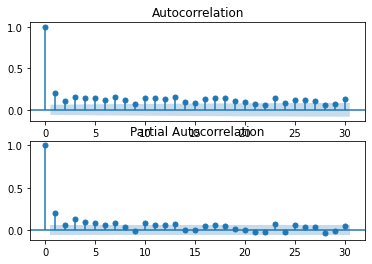

In [47]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3, lags=30, ax=ax[1])
plt.show()

In [48]:
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=4, max_q=6, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=19458.901, BIC=19478.670, Fit time=2.840 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=19454.939, BIC=19464.823, Fit time=0.031 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=19408.873, BIC=19428.641, Fit time=0.479 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=19411.926, BIC=19431.694, Fit time=0.342 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=19412.423, BIC=19427.249, Fit time=0.087 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=19410.829, BIC=19435.540, Fit time=1.729 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=19409.426, BIC=19434.137, Fit time=1.640 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=19410.591, BIC=19440.244, Fit time=4.436 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=19452.272, BIC=19467.099, Fit time=0.369 seconds
Fit ARIMA:

Best ARIMA order=(4, 0, 4) seasonal_order=(1, 0, 0, 12)

Optimization terminated successfully.
         Current function value: 9.347751
         Iterations: 3
         Function evaluations: 359


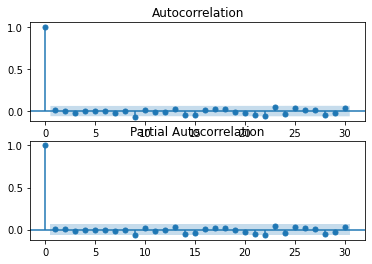

In [49]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(4,0,4), seasonal_order = (1,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [50]:
train = ds_method3.loc['2015-11-29':'2019-03-08']
test = ds_method3.loc['2020-10-14':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(4, 0, 4),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [51]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(4,0,4),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Steps   No. Observations:                 1035
Model:             SARIMAX(4, 0, 4)x(1, 0, [], 12)   Log Likelihood               -9510.130
Date:                             Wed, 18 Nov 2020   AIC                          19040.260
Time:                                     14:53:45   BIC                          19089.526
Sample:                                          0   HQIC                         19058.968
                                            - 1035                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3060      0.295     -1.037      0.300      -0.885       0.273
ar.L2         -0.0366      

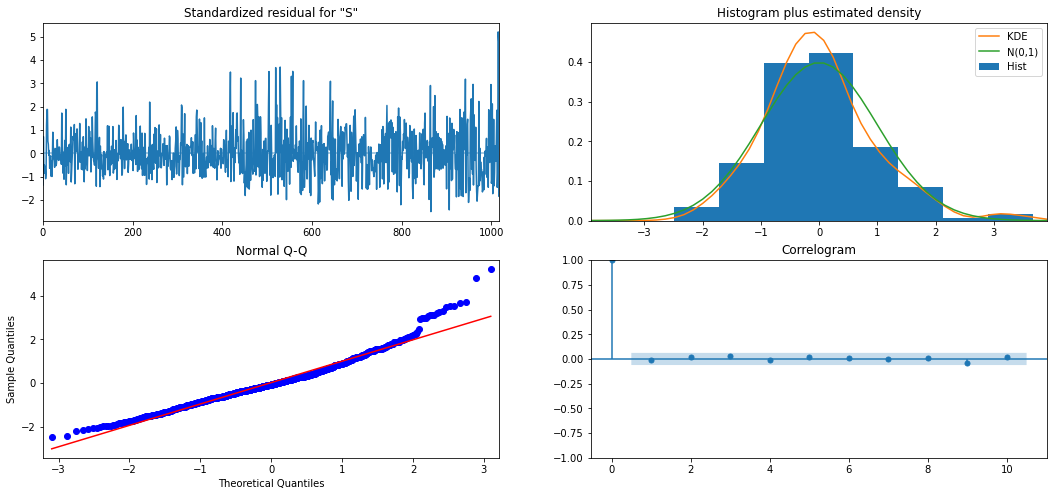

In [52]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [53]:
# the 20% point test data is on the specified date below
split_date = '2019-03-08'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(4,0,4),
                                seasonal_order=(1,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [54]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 12967599.9953
Root Mean Squared Error: 3601.0554
Mean Absolute Error: 2814.6403


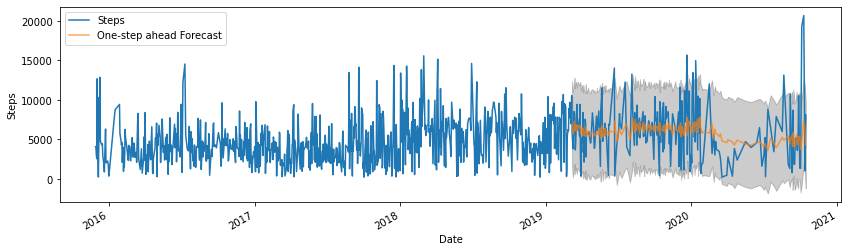

In [55]:
pred = results.get_prediction(start=pd.to_datetime('2019-03-08'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

In [56]:
models = pd.DataFrame({
    'Method': ['Method 1', 'Method 2', 'Method 3'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

,Method,MSE,RMSE,MAE
0,Method 1,1.885813e+07,4342.5952,3419.9546
1,Method 2,1.720450e+07,4147.8302,3247.8271
2,Method 3,1.296760e+07,3601.0554,2814.6403


Based on the above predictions, we can observe that **Method 2** and **Method 3** have a very similar prediction with **Method 1** performing the worst. However, the **RMSE** value of **Model 3** is lower, therefore, we can conclude that the **Method 3** performs the best here.